### 00. Importado as biblíotecas necessárias.

In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset

ModuleNotFoundError: No module named 'surprise'

In [367]:
dfRatings = pd.read_csv('archive/Ratings.csv')

In [368]:
dfUsers = pd.read_csv('archive/Users.csv')

In [369]:
dfBooks = pd.read_csv('archive/Books.csv')

C:\Users\Gabriel Lopes\AppData\Local\Temp\ipykernel_21040\2782996754.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dfBooks = pd.read_csv('archive/Books.csv')


### 01. Explorando o df`s

In [370]:
dfBooks.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


- **ISBN**: O número padrão internacional de livros (International Standard Book Number), um identificador único para cada livro.
- **Book-Title**: O título do livro.
- **Book-Author**: O autor do livro.
- **Year-Of-Publication**: O ano em que o livro foi publicado.
- **Publisher**: A editora que publicou o livro.
- **Image-URL-S**: URL da imagem da capa do livro em tamanho pequeno.
- **Image-URL-M**: URL da imagem da capa do livro em tamanho médio.
- **Image-URL-L**: URL da imagem da capa do livro em tamanho grande.

In [371]:
dfRatings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [372]:
dfUsers.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### DFUSERS

**Analise de idade**

In [373]:
dfUsers.Age.describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

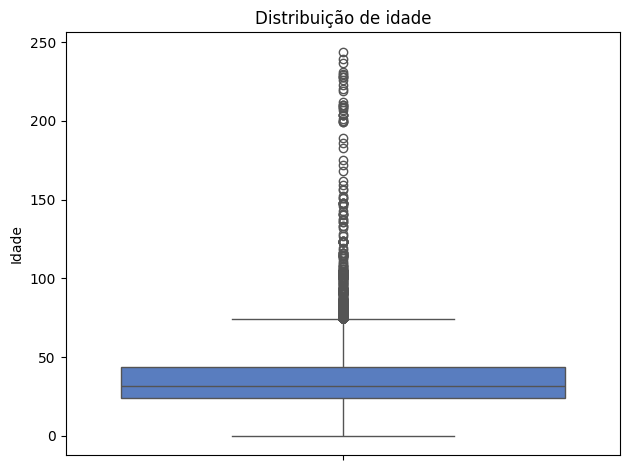

In [374]:
plt.title('Distribuição de idade')
sns.boxplot(dfUsers.Age, color=sns.color_palette("muted")[0])
plt.ylabel('Idade')
plt.tight_layout()

In [375]:
print(f'Valores nulos representam: {(dfUsers.Age.isnull().sum() / dfUsers.shape[0]) * 100:.2f}% na tabela de usuários.')

Valores nulos representam: 39.72% na tabela de usuários.


In [376]:
# Calcular Q1 (25º percentil) e Q3 (75º percentil)
Q1 = dfUsers['Age'].quantile(0.25)
Q3 = dfUsers['Age'].quantile(0.75)

# Calcular IQR
IQR = Q3 - Q1

# Definir limites inferior e superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = dfUsers[(dfUsers['Age'] < lower_bound) | (dfUsers['Age'] > upper_bound)]

outliers.Age.describe()

count    1084.000000
mean       92.965867
std        26.790624
min        75.000000
25%        77.000000
50%        81.000000
75%       104.000000
max       244.000000
Name: Age, dtype: float64

In [377]:
print(f'Outliers representam: {(outliers.shape[0] / dfUsers.shape[0]) * 100:.2f}% na tabela de usuários.')

Outliers representam: 0.39% na tabela de usuários.


In [378]:
# Calcular a porcentagem de usuários com idade menor que 10
percentagem_menor_que_10 = (dfUsers[dfUsers['Age'] < 10].shape[0] / dfUsers.shape[0]) * 100

# Exibir a mensagem formatada
print(f'Valores de usuários com idade menor que 10 representam {percentagem_menor_que_10:.2f}%, sendo 416 com idade igual a 0.')

Valores de usuários com idade menor que 10 representam 0.38%, sendo 416 com idade igual a 0.


**Analise de localização**

In [379]:
# Supondo que a coluna 'Location' tenha o formato "Cidade, Estado, País"
# Dividir a coluna 'Location' em no máximo três partes
location_split = dfUsers['Location'].str.split(',', n=2, expand=True)

# Renomear as colunas resultantes
location_split.columns = ['City', 'State', 'Country']

# Preencher valores ausentes com strings vazias
location_split = location_split.fillna('')

# Normalizar os dados (remover espaços extras e converter para maiúsculas)
location_split['Country'] = location_split['Country'].str.strip().str.upper()

# Adicionar as novas colunas ao DataFrame original
dfUsers = dfUsers.join(location_split)

# Verificar quantos países únicos existem
unique_countries = dfUsers['Country'].nunique()
print(f"Número de países únicos: {unique_countries}")

# Verificar os países únicos
print(dfUsers['Country'].unique())

Número de países únicos: 1259
['USA' 'RUSSIA' 'PORTUGAL' ... 'LA SVIZZERA' 'HERNANDO' 'UNITED KINGDOM.']


In [380]:
dfUsers['Country'].nunique()

1259

**Explorando alguns conceitos do notebook**

In [381]:
books_ratings = dfBooks.merge(dfRatings, left_on='ISBN', right_on='ISBN')
books_ratings

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0
...,...,...,...,...,...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,276463,7
1031132,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,276579,4
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,276680,0
1031134,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,276680,0


In [382]:
books_ratings = books_ratings[['ISBN', 'Book-Title', 'Book-Author', 'User-ID', 'Book-Rating']]
books_ratings.reset_index(drop=True, inplace=True)
books_ratings

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,41385,0
...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,276463,7
1031132,0525447644,From One to One Hundred,Teri Sloat,276579,4
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,276680,0
1031134,0192126040,Republic (World's Classics),Plato,276680,0


In [383]:
books_ratings['Book-Rating'].value_counts()

Book-Rating
0     647294
8      91804
10     71225
7      66402
9      60778
5      45355
6      31687
4       7617
3       5118
2       2375
1       1481
Name: count, dtype: int64

In [384]:
d = {}
for i, j in enumerate(books_ratings['ISBN'].unique()):
    d[j] = i

In [385]:
books_ratings['Unique-book-id'] = books_ratings['ISBN'].map(d)

C:\Users\Gabriel Lopes\AppData\Local\Temp\ipykernel_21040\3598038191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_ratings['Unique-book-id'] = books_ratings['ISBN'].map(d)


In [386]:
books_ratings

,ISBN,Book-Title,Book-Author,User-ID,Book-Rating,Unique-book-id
0,0195153448,Classical Mythology,Mark P. O. Morford,2,0,0
1,0002005018,Clara Callan,Richard Bruce Wright,8,5,1
2,0002005018,Clara Callan,Richard Bruce Wright,11400,0,1
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8,1
4,0002005018,Clara Callan,Richard Bruce Wright,41385,0,1
...,...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,276463,7,270146
1031132,0525447644,From One to One Hundred,Teri Sloat,276579,4,270147
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,276680,0,270148
1031134,0192126040,Republic (World's Classics),Plato,276680,0,270149


In [387]:
from scipy.sparse import csr_matrix

In [388]:
# Converter colunas para tipos adequados
books_ratings['User-ID'] = books_ratings['User-ID'].astype('category').cat.codes
books_ratings['Unique-book-id'] = books_ratings['Unique-book-id'].astype('category').cat.codes
books_ratings['Book-Rating'] = books_ratings['Book-Rating'].astype(float)

C:\Users\Gabriel Lopes\AppData\Local\Temp\ipykernel_21040\92150425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_ratings['User-ID'] = books_ratings['User-ID'].astype('category').cat.codes
C:\Users\Gabriel Lopes\AppData\Local\Temp\ipykernel_21040\92150425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_ratings['Unique-book-id'] = books_ratings['Unique-book-id'].astype('category').cat.codes
C:\Users\Gabriel Lopes\AppData\Local\Temp\ipykernel_21040\92150425.py:4: SettingWithCopyWarning: 


In [389]:
user_id = books_ratings['User-ID'].values
book_id = books_ratings['Unique-book-id'].values
rating = books_ratings['Book-Rating'].values

In [390]:
sparse_matrix = csr_matrix((rating, (user_id, book_id)))

In [391]:
print(sparse_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1031136 stored elements and shape (92106, 270151)>
  Coords	Values
  (0, 0)	0.0
  (1, 1)	5.0
  (1, 2)	0.0
  (1, 3)	0.0
  (1, 4)	0.0
  (1, 5)	0.0
  (1, 6)	0.0
  (1, 7)	0.0
  (1, 8)	0.0
  (1, 9)	5.0
  (1, 10)	0.0
  (1, 11)	0.0
  (1, 12)	5.0
  (1, 13)	5.0
  (1, 14)	0.0
  (1, 15)	6.0
  (1, 16)	6.0
  (1, 17)	7.0
  (2, 18)	0.0
  (2, 19)	6.0
  (2, 20)	0.0
  (3, 21)	0.0
  (4, 22)	10.0
  (5, 23)	5.0
  (5, 24)	5.0
  :	:
  (92103, 64134)	0.0
  (92103, 64135)	0.0
  (92103, 65695)	8.0
  (92103, 85962)	0.0
  (92103, 103032)	7.0
  (92103, 187380)	7.0
  (92103, 199972)	0.0
  (92103, 229511)	5.0
  (92103, 248395)	0.0
  (92103, 248396)	0.0
  (92103, 248397)	7.0
  (92103, 248398)	0.0
  (92103, 248399)	5.0
  (92103, 248400)	7.0
  (92103, 248401)	7.0
  (92103, 248402)	10.0
  (92104, 76773)	8.0
  (92105, 3566)	8.0
  (92105, 5412)	7.0
  (92105, 9082)	7.0
  (92105, 9530)	7.0
  (92105, 20326)	0.0
  (92105, 43693)	0.0
  (92105, 95494)	6.0
  (92105, 1

In [392]:
from scipy.sparse.linalg import svds

In [393]:
# Aplicar SVD na matriz esparsa
k = 15

U, sigma, Vt = svds(sparse_matrix, k=k)  # k é o número de componentes singulares

# Verificar os resultados
print("U shape:", U.shape)
print("Sigma shape:", sigma.shape)
print("Vt shape:", Vt.shape)

U shape: (92106, 15)
Sigma shape: (15,)
Vt shape: (15, 270151)


In [ ]:
U = U[:, :k]
sigma = sigma[:k]
Vt = Vt[:k, :]

In [397]:
U_sparse = csr_matrix(U)
sigma_sparse = csr_matrix(sigma)
Vt_sparse = csr_matrix(Vt)